# Modeling the LMC high mass X-ray binaries population with MCMC

### Jeff J. Andrews, Andreas Zezas, Tassos Fragos, et al.

In [1]:
import os
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.interpolate import interp1d, interp2d
from scipy.stats import maxwell, norm, uniform, powerlaw, truncnorm
from scipy import optimize
import emcee
import corner

%matplotlib inline

### Constants

In [10]:
G = 6.674e-8 # Gravitational constant in cgs
GGG = 1.909e5 # Gravitational constant in Rsun * (km/s)^2 / Msun
km_to_cm = 1.0e5 # km to cm
Msun_to_g = 1.989e33 # Msun to g
Rsun_to_cm = 6.995e10 # Rsun to cm
AU_to_cm = 1.496e13 # AU to cm
pc_to_cm = 3.086e18 # parsec to cm
pc_to_km = 3.086e13 # parsec to km
yr_to_sec = 31557600.0 # Sec in yr
asec_to_rad = 4.84814e-6 # Arcsec to radians

M_0 = 0.073 # in Msun
xi = 0.704
M_NS = 1.35
#v_wind = 1000.0 # companion velocity in km/s
R_NS = 12.0  # NS radius in km

### Load SSE data

In [11]:
names = ["time","mass","mdot","radius"]

f_list = glob.glob("../data/sse_data/mdot_*.dat")

f_list = np.sort(f_list)

# Create empty data storage structure
sse_data = np.recarray(0, names=names, formats=['f8,float64,float64'])

func_sse_mdot = np.array([])
func_sse_mass = np.array([])
func_sse_radius = np.array([])
sse_tmp_mass = np.array([])
sse_tmp_time = np.array([])
sse_tmp_radius = np.array([])

for f in f_list:
    datafile = os.path.abspath(f)
    sse_tmp_data = np.genfromtxt(datafile, usecols=(0,2,3,4), dtype="f8,float64,float64,float64", skip_header=1, names=names)
    
#    func_sse_mass = np.append(func_sse_mass, interp1d(sse_tmp_data["time"], sse_tmp_data["mass"], bounds_error=False, fill_value=0.0))    
#    func_sse_mdot = np.append(func_sse_mdot, interp1d(sse_tmp_data["time"], sse_tmp_data["mdot"], bounds_error=False, fill_value=0.0))
    func_sse_mass = np.append(func_sse_mass, interp1d(sse_tmp_data["time"], sse_tmp_data["mass"], bounds_error=False, fill_value=sse_tmp_data["mass"][-1]))    
    func_sse_mdot = np.append(func_sse_mdot, interp1d(sse_tmp_data["time"], sse_tmp_data["mdot"], bounds_error=False, fill_value=0.0))
    func_sse_radius = np.append(func_sse_radius, interp1d(sse_tmp_data["time"], sse_tmp_data["radius"], bounds_error=False, fill_value=0.0))
    
    sse_tmp_time = np.append(sse_tmp_time, max(sse_tmp_data["time"])-1.0)
    sse_tmp_mass = np.append(sse_tmp_mass, sse_tmp_data["mass"][0])
    sse_tmp_radius = np.append(sse_tmp_radius, max(sse_tmp_data["radius"]))
    
# Lifetime function
func_sse_tmax = interp1d(sse_tmp_mass, sse_tmp_time, bounds_error=False, fill_value=0.0)
func_sse_min_mass = interp1d(sse_tmp_time, sse_tmp_mass, bounds_error=False, fill_value=1.0)
func_sse_rmax = interp1d(sse_tmp_radius, sse_tmp_time, bounds_error=False, fill_value=0.0)

In [12]:
def func_get_sse_star(mass, time):

    mass_out = np.array([])
    mdot_out = np.array([])
    radius_out = np.array([])

    if isinstance(mass, np.ndarray):
        
        if len(mass) == 1:
            mass_out = np.append(mass_out, func_sse_mass[int(mass*100.0)-100](time))
            mdot_out = np.append(mdot_out, func_sse_mdot[int(mass*100.0)-100](time))        
            radius_out = np.append(radius_out, func_sse_radius[int(mass*100.0)-100](time))
        else:
            for i in np.arange(len(mass)):
                if (int(mass[i]*100.0)-100<0 or int(mass[i]*100.0)-100>len(func_sse_mass)): continue
                mass_out = np.append(mass_out, func_sse_mass[int(mass[i]*100.0)-100](time[i]))
                mdot_out = np.append(mdot_out, func_sse_mdot[int(mass[i]*100.0)-100](time[i]))
                radius_out = np.append(radius_out, func_sse_radius[int(mass[i]*100.0)-100](time[i]))
    else:
        mass_out = np.append(mass_out, func_sse_mass[int(mass*100.0)-100](time))
        mdot_out = np.append(mdot_out, func_sse_mdot[int(mass*100.0)-100](time))
        radius_out = np.append(radius_out, func_sse_radius[int(mass*100.0)-100](time))
            
    return mass_out, mdot_out, radius_out
    

In [13]:
names = ["mass","he_mass","t_ms"]
f = "../data/sse_data/He_star.dat"

sse_he_star = np.genfromtxt(os.path.abspath(f), usecols=(0,1,2), names=names)

func_sse_he_mass = interp1d(sse_he_star["mass"], sse_he_star["he_mass"], bounds_error=False, fill_value=0.001)
func_sse_ms_time = interp1d(sse_he_star["mass"], sse_he_star["t_ms"], bounds_error=False, fill_value=-1.0e10)

### The first mass transfer phase

In [14]:
# To Do: Check for thermal timescale MT criterion

def func_MT_forward(M_1_in, M_2_in, A_in):

    M_1_out = M_0 * M_1_in**(1./xi)
    M_2_out = M_1_in + M_2_in - M_1_out
    A_out = A_in * (M_1_in*M_2_in/M_1_out/M_2_out)*(M_1_in*M_2_in/M_1_out/M_2_out)

    return M_1_out, M_2_out, A_out
    
def func_MT_backward(M_1_in, M_2_in, A_in):
    
    M_1_out = (M_1_in/M_0)**xi
    M_2_out = M_2_in - M_1_out + M_1_in
    A_out = A_in * (M_1_in*M_2_in/M_1_out/M_2_out)*(M_1_in*M_2_in/M_1_out/M_2_out)

    return M_1_out, M_2_out, A_out

### The supernova

In [15]:
# To Do: What to do about ECS kicks

def func_SN_forward(M_1_in, M_2, A_in, v_k, theta, phi):
    
    v_r = np.sqrt(GGG*(M_1_in + M_2)/A_in)
    v_1 = np.sqrt(2.0*v_k*v_r*np.cos(theta) + v_k*v_k + v_r*v_r)
    
    A_out = 1.0 / (2.0/A_in - v_1*v_1/(GGG*(M_NS+M_2)))
#    v_sys = (M_NS / (M_NS + M_2)) * v_1
    
    # Systemic velocity    
    alpha = (M_1_in / (M_1_in + M_2))    
    beta = (M_NS / (M_NS + M_2))
    
    v_sys = beta*beta*v_k*v_k
    v_sys = v_sys + v_r*v_r*(beta-alpha)*(beta-alpha)
    v_sys = v_sys + 2.0*beta*v_k*v_r*np.cos(theta)*(beta-alpha)
    v_sys = np.sqrt(v_sys)
    
    # Eccentricity
    e_tmp = v_k*v_k*np.cos(theta)*np.cos(theta) 
    e_tmp = e_tmp + v_k*v_k*np.sin(theta)*np.sin(theta)*np.sin(phi)*np.sin(phi) 
    e_tmp = e_tmp + 2.0*v_k*v_r*np.cos(theta)
    e_tmp = e_tmp + v_r*v_r
    e_tmp = 1.0 - (A_in*A_in)/(A_out*GGG*(M_NS+M_2)) * e_tmp
        
    if isinstance(e_tmp, np.ndarray):
        ecc = np.array([np.sqrt(x) if x > 0.0 or M_2 > min_mass else -1.0 for x in e_tmp])
    else:
        if e_tmp < 0.0 or M_2 > min_mass: return A_out, v_sys, -1.0
        ecc = np.sqrt(e_tmp)
    
    return A_out, v_sys, ecc


### The wind accreting phase

In [16]:
# To Do: What happens when companion's lifetime falls between primary's MS lifetime and stellar lifetime?
# To Do: Remove RLOF systems

def func_get_time(M1, M2, t_obs):

    t_lifetime_1 = func_sse_ms_time(M1)
    he_mass_1 = func_sse_he_mass(M1)
    
    t_lifetime_2 = func_sse_ms_time(M2)
    he_mass_2 = func_sse_he_mass(M2)
    
    # Relative lifetime through star 2 at mass gain
    he_mass = t_lifetime_1/t_lifetime_2 * he_mass_2
    
    # Get new secondary parameters
    mass_new = M2 + M1 - he_mass_1
    t_lifetime_new = func_sse_ms_time(mass_new)
    he_mass_new = func_sse_he_mass(mass_new)

    # New, effective lifetime
    t_eff = he_mass / he_mass_new * t_lifetime_new
    
    # Now, we obtain the "effective observed time"
    return t_eff + t_obs - t_lifetime_1
         
    
    
def get_v_wind(mass, radius):
    
    slope = (7.0 - 0.5) / (120.0 - 1.4)
    intercept = 7.0 - 120.0 * slope
    
    beta = slope * mass + intercept
    
    return np.sqrt(2.0 * beta * GGG * mass / radius)
    
    
    
def func_Lx_forward(M_1_a, M_2_a, M_2_in, A_in, t_obs):
    
    t_eff_obs = func_get_time(M_1_a, M_2_a, t_obs)
    
    if isinstance(t_eff_obs, np.ndarray):
        M_2_out = np.array([])
        M_dot_wind = np.array([])
        R_out = np.array([])
        for i in np.arange(len(t_eff_obs)):
            if (t_eff_obs[i] < 0.0): 
                if isinstance(M_2_in, np.ndarray):
                    M_2_out = np.append(M_2_out, M_2_in[i])
                else:
                    M_2_out = np.append(M_2_out, M_2_in)
                M_dot_wind = np.append(M_dot_wind, 0.0)
                R_out = np.append(R_out, 0.0)
            else:
                if isinstance(M_2_in, np.ndarray):
                    if M_2_in[i] > max_mass: 
                        a, b, c = 0.0, 0.0, 0.0
                    else:
                        a, b, c = func_get_sse_star(M_2_in[i], t_eff_obs[i])
                else:
                    if M_2_in > max_mass: 
                        a, b, c = 0.0, 0.0, 0.0
                    else:
                        a, b, c = func_get_sse_star(M_2_in, t_eff_obs[i])

                M_2_out = np.append(M_2_out, a)
                M_dot_wind = np.append(M_dot_wind, b)    
                R_out = np.append(R_out, c)
    else:
        if (t_eff_obs < 0.0 or M_2_in > max_mass): 
            M_2_out = M_2_in
            M_dot_wind = 0.0
            R_out = 0.0
        else:
            M_2_out, M_dot_wind, R_out = func_get_sse_star(M_2_in, t_eff_obs)

    # Get wind velocity
    v_wind = get_v_wind(M_2_out, R_out)
    
    # Get final orbital separation
    A_out = (M_NS + M_2_in) / (M_NS + M_2_out) * A_in
    
    f_capture = (GGG*M_NS / (v_wind*v_wind*A_out))**2
    M_dot_out = f_capture * M_dot_wind
        
    L_bol = GGG * M_NS * M_dot_out / R_NS * km_to_cm * Msun_to_g * Rsun_to_cm / yr_to_sec
    L_x = L_bol
        
    
    return M_2_out, L_x
    
    
    
def func_Lx_backward(M_1_a, M_2_a, M_2_in, L_x, t_obs):

    p = [M_1_a, M_2_a, M_2_in, L_x, t_obs]

    # Root finder to get secondary mass
    init_val = M_2_in
    sol = optimize.root(func_wrapper_Lx, x0 = init_val, args=p, method='hybr', options={'xtol':1.0e-3, 'eps':1.0e-3})
    M_2_out = sol.x

    if M_2_out < 1.0 or M_2_out > 39.0: return -1.0, -1.0
    
    # Now, to get orbital separation
    t_eff_obs = func_get_time(M_1_a, M_2_a, t_obs)
    M_2_tmp, M_dot_wind = func_get_sse_star(M_2_out, t_eff_obs)
    
    M_dot_acc = L_x / ( GGG * M_NS / R_NS * km_to_cm * Msun_to_g * Rsun_to_cm / yr_to_sec )
    A_tmp = (GGG*M_NS / (v_wind*v_wind)) * np.sqrt(M_dot_wind/M_dot_acc)
    A_out = (M_NS + M_2_in) / (M_NS + M_2_out) * A_tmp


    return sol.x, A_out
    
    
    
def func_wrapper_Lx(x, p):

    M_1_a, M_2_a, M_2_in, L_x, t_obs = p

    if x[0]<1.0 or x[0]>39.0: return np.inf
    
    M_2_tmp, L_x_tmp = func_Lx_forward(M_1_a, M_2_a, x[0], 1.0e3, t_obs)

    return float(abs(M_2_tmp - M_2_in))
#    return [float(abs(M_2_tmp - M_2_in)), float(abs(L_x_tmp - L_x)) ]


## Now let's put together the MCMC functions

In [17]:
min_mass = 8.0
max_mass = 39.0
min_A = 1.0e2
max_A = 1.0e4
v_k_sigma = 265.0
alpha = -2.35

dist_LMC = 5.0e4 * pc_to_km # Distance in km

### Priors

In [18]:
# Priors
def ln_priors(y):
    
    M1, M2, A, v_k, theta, phi, t_obs = y
    
    lp = 0.0
        
    # M1
    if M1 < min_mass or M1 > max_mass: return -np.inf
    norm_const = (alpha+1.0) / (np.power(max_mass, alpha+1.0) - np.power(min_mass, alpha+1.0))
    lp += np.log( norm_const * np.power(M1, alpha) )

    # M2
    q = M2 / M1
    if q < 0.3 or q > 1.0: return -np.inf
    lp += np.log( (1.0 / 0.7) * (1.0 / M1 ) )

    # A
    if A < min_A or A > max_A: return -np.inf
    norm_const = np.log(max_A) - np.log(min_A)
    lp += np.log( norm_const / A )

    # v_k
    if v_k < 0.0: return -np.inf
    lp += np.log( maxwell.pdf(v_k, scale=v_k_sigma) )

    # theta
    if theta < 0.0 or theta > np.pi: return -np.inf
    lp += np.log(np.sin(theta) / 2.0)

    # phi
    if phi < 0.0 or phi > 2.0*np.pi: return -np.inf
    lp += -np.log( 2.0*np.pi )

    # Add a prior so that the post-MT secondary is within the correct bounds
    M2_c = M1 + M2 - 0.073 * np.power(M1, 1.0/0.704)
    if M2_c > max_mass or M2_c < min_mass: return -np.inf

    # M1 must be massive enough to evolve off the MS by t_obs
    if func_sse_tmax(M1) > t_obs: return -np.inf
    
    # Add a prior so the effective time remains bounded
    t_eff_obs = func_get_time(M1, M2, t_obs)
    if t_eff_obs < 0.0: return -np.inf

    return lp

### Posterior function

In [19]:
def ln_posterior(x, args):
    
    M1, M2, A, v_k, theta, phi = x
    M2_d, L_x, theta_proj, t_obs = args
    
    # Call priors    
    y = M1, M2, A, v_k, theta, phi, t_obs
    lp = ln_priors(y)
    if np.isinf(lp): return -np.inf
    
    ll = 0

    M1_b, M2_b, A_b = func_MT_forward(M1, M2, A)
    A_c, v_sys, ecc = func_SN_forward(M1_b, M2_b, A_b, v_k, theta, phi)
    M2_d_out, L_x_out = func_Lx_forward(M1, M2, M2_b, A_c, t_obs)
     
    # If system disrupted, return -infty
    if ecc < 0.0 or ecc > 1.0 or np.isnan(ecc): return -np.inf
    
    # Observed secondary mass
    delta_M_err = 0.2
    coeff_M = -0.5 * np.log( 2. * np.pi * delta_M_err*delta_M_err )
    argument_M = -( M2_d - M2_d_out ) * ( M2_d - M2_d_out ) / ( 2. * delta_M_err*delta_M_err )
    ll += coeff_M + argument_M

    # Observed X-ray luminosity
    delta_ln_L_x_err = 0.2
    coeff_ln_L_x = -0.5 * np.log( 2. * np.pi * delta_ln_L_x_err*delta_ln_L_x_err )
    argument_ln_L_x = -( np.log(L_x) - np.log(L_x_out) ) * ( np.log(L_x) - np.log(L_x_out) ) / ( 2. * delta_ln_L_x_err*delta_ln_L_x_err )
    ll += coeff_ln_L_x + argument_ln_L_x

    # Observed distance from the birth cluster
    t_travel = (t_obs - func_sse_tmax(M1)) * 1.0e6 * yr_to_sec
    sin_theta = theta_proj * dist_NGC55 / (v_sys * t_travel)
    if sin_theta < 0.0 or sin_theta > 1.0: return -np.inf  # sine must be bounded

    cos_theta = np.sqrt(1.0 - sin_theta*sin_theta)
    prob = sin_theta / cos_theta * v_sys * t_travel / dist_NGC55
    ll += np.log(prob)
    
#     ############## TESTING ##############
#     v_sys_tmp = theta_proj
#     delta_tmp = 5.0
#     coeff_tmp = -0.5 * np.log( 2. * np.pi * delta_tmp*delta_tmp )
#     argument_tmp = -( v_sys - v_sys_tmp ) * ( v_sys - v_sys_tmp ) / ( 2. * delta_tmp*delta_tmp )
#     ll += coeff_tmp + argument_tmp
#     ############## TESTING ##############
    
    
    if np.isnan(ll): return -np.inf
        
    return ll + lp

### emcee wrapper

In [20]:
# This function runs emcee
def run_emcee(M2_d, L_x, theta_proj, t_obs, nburn=1000, nsteps=1000):

    
    # Get initial values
    initial_masses = get_initial_values(M2_d, L_x, theta_proj, t_obs)

    
    # Define sampler
    nwalkers = 32
    args = [[M2_d, L_x, theta_proj, t_obs]]
    sampler = emcee.EnsembleSampler(nwalkers=nwalkers, dim=6, lnpostfn=ln_posterior, args=args)

    
    # Assign initial values
    p0 = np.zeros((nwalkers,6))
    p0 = set_walkers(initial_masses, args[0])

    
    # Burn-in
    pos,prob,state = sampler.run_mcmc(p0, N=nburn)

    
    # Full run
    sampler.reset()
    pos,prob,state = sampler.run_mcmc(pos, N=nsteps)
    
    
    return sampler

def set_walkers(initial_masses, args, nwalkers=32):
    
    M2_d, L_x, theta_proj, t_obs = args   
    
    p0 = np.zeros((nwalkers,6))
    p0[:,0] = initial_masses.T[0]
    p0[:,1] = initial_masses.T[1]
    
    p0[:,2] = np.power(10.0, np.random.uniform(2.0, 3.0, size=nwalkers)) # A
#    p0[:,2] = np.random.normal(500.0, 100.0, size=nwalkers) # A
    p0[:,3] = np.random.normal(50.0, 10.0, size=nwalkers) # v_k
    p0[:,4] = np.random.normal(np.pi, 0.2, size=nwalkers) # theta
    p0[:,5] = np.random.normal(1.0, 0.2, size=nwalkers) # phi  

    for i in np.arange(nwalkers):
        counter = 0
        
        prob = ln_posterior(p0[i], args)
        while(np.isinf(prob)):
            p0[i,2] = np.power(10.0, np.random.uniform(2.0, 3.0)) # A
#            p0[i,2] = np.random.normal(500.0, 100.0) # A
            p0[i,3] = np.random.normal(50.0, 10.0) # v_k
            p0[i,4] = np.random.normal(np.pi, 0.2) # theta
            p0[i,5] = np.random.normal(1.0, 0.2) # phi  
            prob = ln_posterior(p0[i], args)
            
            counter += 1
            
            if counter > 100: break
                
    return p0

### Choose initial values

In [21]:
def get_initial_values(M2_d, L_x, theta_proj, t_obs):

#     ############# TEST ###############
#     # Initial values
#     M1_start = 30.0
#     M2_start = 4.0
#     A_start = 1.0e3
#     v_k_start = 20.0
#     theta_start = 0.8*np.pi
#     phi_start = 0.2*np.pi
#     x0 = [M1_start, M2_start, A_start, v_k_start, theta_start, phi_start]
#     ############# TEST ###############


    # Start by using MCMC on just the masses to get a distribution of M1 and M2
    nwalkers = 32
    
    args = [[M2_d, t_obs]]
    sampler = emcee.EnsembleSampler(nwalkers=nwalkers, dim=2, lnpostfn=ln_posterior_initial, args=args)
    
    # Picking the initial masses will need to be optimized
    p_i = [M2_d*0.6, M2_d*0.5]
    t_eff_obs = func_get_time(p_i[0], p_i[1], t_obs)
    M_b_prime = p_i[0] + p_i[1] - 0.073*np.power(p_i[0], 1.0/0.704)
    M_tmp, Mdot_tmp, R_tmp = func_get_sse_star(M_b_prime, t_eff_obs)

    min_M = func_sse_min_mass(t_obs)
    
    n_tries = 0
    while t_eff_obs < 0.0 or Mdot_tmp == 0.0:
        
        p_i[0] = (max_mass - min_M) * np.random.uniform() + min_M
        p_i[1] = (0.7 * np.random.uniform() + 0.3) * p_i[0]

        t_eff_obs = func_get_time(p_i[0], p_i[1], t_obs)
        if t_eff_obs < 0.0: continue

        M_b_prime = p_i[0] + p_i[1] - 0.073*np.power(p_i[0], 1.0/0.704)
        if M_b_prime > max_mass: continue
            
        M_tmp, Mdot_tmp, R_tmp = func_get_sse_star(M_b_prime, t_eff_obs)
        
        # Exit condition        
        n_tries += 1
        if n_tries > 100: break
    
    # initial positions for walkers
    p0 = np.zeros((nwalkers,2))
    a, b = (min_M - p_i[0]) / 0.5, (max_mass - p_i[0]) / 0.5
    p0[:,0] = truncnorm.rvs(a, b, loc=p_i[0], scale=1.0, size=nwalkers)
    p0[:,1] = np.random.normal(p_i[1], 0.5, size=nwalkers) # M2

    # burn-in
    pos,prob,state = sampler.run_mcmc(p0, N=100)
    
    return pos    

### Initial values posterior, prior functions

In [22]:
# The posterior function for the initial parameters
def ln_posterior_initial(x, args):

    M1, M2 = x
    M2_d, t_obs = args

    y = M1, M2, M2_d, t_obs
    lp = ln_priors_initial(y)
    if np.isinf(lp): return -np.inf
        
    # Get observed mass, mdot
    t_eff_obs = func_get_time(M1, M2, t_obs)
    M2_c = M1 + M2 - 0.073 * np.power(M1, 1.0/0.704)
    M2_tmp, M2_dot, R_tmp = func_get_sse_star(M2_c, t_eff_obs)
    
    # Somewhat arbitrary definition of mass error
    delta_M_err = 1.0
    coeff = -0.5 * np.log( 2. * np.pi * delta_M_err*delta_M_err )
    argument = -( M2_d - M2_tmp ) * ( M2_d - M2_tmp ) / ( 2. * delta_M_err*delta_M_err )
        
    return coeff + argument + lp

# Prior function for the initial parameters
def ln_priors_initial(x):
    M1, M2, M2_d, t_obs = x

    # M1
    if M1 < min_mass or M1 > max_mass: return -np.inf

    # M2
    if M2 < 0.3*M1 or M2 > M1: return -np.inf

    # Add a prior so that the post-MT secondary is within the correct bounds
    M2_c = M1 + M2 - 0.073 * np.power(M1, 1.0/0.704)
    if M2_c > max_mass or M2_c < min_mass: return -np.inf

    # Add a prior so the primary can go through a SN by t_obs
    if func_sse_tmax(M1) > t_obs: return -np.inf
    
    # Add a prior so the effective time remains bounded
    t_eff_obs = func_get_time(M1, M2, t_obs)
    if t_eff_obs < 0.0: return -np.inf

    # Add a prior so that only those masses with a non-zero Mdot are allowed
    M2_tmp, M2_dot, R_tmp = func_get_sse_star(M2_c, t_eff_obs)
    if M2_dot == 0.0: return -np.inf
    
    return 0.0

In [23]:
def full_forward(M1, M2, A, v_k, theta, phi, t_obs):

    # MT phase
    M_1_b, M_2_b, A_b = func_MT_forward(M1, M2, A)

    # SN
    A_tmp, v_sys_tmp, e_tmp = func_SN_forward(M_1_b, M_2_b, A_b, v_k, theta, phi)
    
    # XRB
    M_2_tmp, L_x_tmp = func_Lx_forward(M1, M2, M_2_b, A_tmp, t_obs)

    return M_2_tmp, L_x_tmp, v_sys_tmp

### Forward population synthesis test

In [16]:
# Define random deviate functions

def get_v_k(sigma, N):
    return maxwell.rvs(scale = sigma, size = N)

def get_theta(N):
    return np.arccos(1.0-2.0*uniform.rvs(size = N))

def get_phi(N):
    return 2.0*np.pi*uniform.rvs(size = N)

def get_M1(x1, x2, alpha, N):

    A = (alpha+1.0) / (np.power(x2, alpha+1.0) - np.power(x1, alpha+1.0))
    x = uniform.rvs(size = N)
    
    return np.power(x*(alpha+1.0)/A + np.power(x1, alpha+1.0), 1.0/(alpha+1.0))
    
# Mass ratio - uniform [0.3,1.0]
def get_q(N):
    return 0.7 * uniform.rvs(size = N) + 0.3 
    
def get_A(a1, a2, N):
    x1 = np.log10(a1)
    x2 = np.log10(a2)
    
    return np.power(10.0, (x2-x1)*uniform.rvs(size=N) + x1)

In [17]:
# Get random deviates

N = 100000     # Number of random values to obtain
n_bins = 100   # Number of bins for histogram

M1_min = 8.0   # Minimum primary mass
M1_max = 30.0  # Maximum primary mass
alpha = -2.35  # IMF power law index
sigma_Fe = 265.0  # Kick velocity maxwellian dispersion - Fe-core SN
sigma_ECS = 50.0  # Kick velocity maxwellian dispersion - ECS
ECS_Fe_mass = 10.0  # Mass differentiating ECS from Fe-core collapse
A_min = 100.0  # Minimum orbital separation (Rsun)
A_max = 2.0e5  # Maximum orbital separation (Rsun) roughly 10^3 AU


theta = get_theta(N)
phi = get_phi(N)
M_1_a = get_M1(M1_min, M1_max, alpha, N)
M_2_a = get_q(N) * M_1_a
A_a = get_A(A_min, A_max, N)

# Kick velocities depend on the core mass
sigma = map(lambda m: sigma_ECS if m<ECS_Fe_mass else sigma_Fe, M_1_a)
v_k = get_v_k(sigma, N)



-c:35: RuntimeWarning: divide by zero encountered in divide
-c:35: RuntimeWarning: invalid value encountered in divide
-c:12: RuntimeWarning: invalid value encountered in greater
-c:13: RuntimeWarning: invalid value encountered in greater
-c:20: RuntimeWarning: invalid value encountered in greater
-c:21: RuntimeWarning: invalid value encountered in greater
-c:28: RuntimeWarning: invalid value encountered in greater
-c:29: RuntimeWarning: invalid value encountered in greater
-c:36: RuntimeWarning: invalid value encountered in greater
-c:37: RuntimeWarning: invalid value encountered in greater


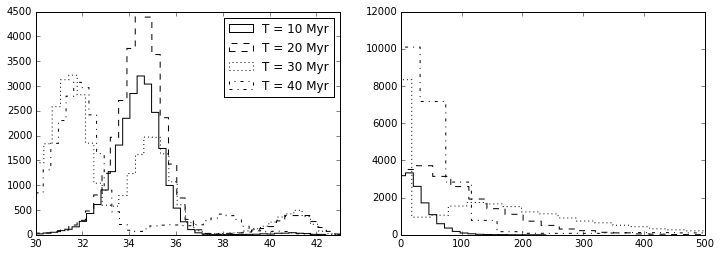

In [18]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)



t_obs = 10.0
M_1_b, M_2_b, A_b = func_MT_forward(M_1_a, M_2_a, A_a)
A_tmp, v_sys_tmp, e_tmp = func_SN_forward(M_1_b, M_2_b, A_b, v_k, theta, phi)
dist = v_sys_tmp * (t_obs - func_sse_tmax(M_1_a)) * km_to_cm / pc_to_cm * 1.0e6 * yr_to_sec
M_2_tmp, L_x_tmp = func_Lx_forward(M_1_a, M_2_a, M_2_b, A_tmp, t_obs)
ax1.hist(np.log10(L_x_tmp[L_x_tmp>1.0e30]), color='k', histtype='step', linestyle='solid', bins=40, label='T = 10 Myr')
ax2.hist(dist[L_x_tmp>1.0e30], color='k', histtype='step', linestyle='solid', bins=40)

t_obs = 20.0
M_1_b, M_2_b, A_b = func_MT_forward(M_1_a, M_2_a, A_a)
A_tmp, v_sys_tmp, e_tmp = func_SN_forward(M_1_b, M_2_b, A_b, v_k, theta, phi)
dist = v_sys_tmp * (t_obs - func_sse_tmax(M_1_a)) * km_to_cm / pc_to_cm * 1.0e6 * yr_to_sec
M_2_tmp, L_x_tmp = func_Lx_forward(M_1_a, M_2_a, M_2_b, A_tmp, t_obs)
ax1.hist(np.log10(L_x_tmp[L_x_tmp>1.0e30]), color='k', histtype='step', linestyle='dashed', bins=40, label='T = 20 Myr')
ax2.hist(dist[L_x_tmp>1.0e30], color='k', histtype='step', linestyle='dashed', bins=40)

t_obs = 30.0
M_1_b, M_2_b, A_b = func_MT_forward(M_1_a, M_2_a, A_a)
A_tmp, v_sys_tmp, e_tmp = func_SN_forward(M_1_b, M_2_b, A_b, v_k, theta, phi)
dist = v_sys_tmp * (t_obs - func_sse_tmax(M_1_a)) * km_to_cm / pc_to_cm * 1.0e6 * yr_to_sec
M_2_tmp, L_x_tmp = func_Lx_forward(M_1_a, M_2_a, M_2_b, A_tmp, t_obs)
ax1.hist(np.log10(L_x_tmp[L_x_tmp>1.0e30]), color='k', histtype='step', linestyle='dotted', bins=40, label='T = 30 Myr')
ax2.hist(dist[L_x_tmp>1.0e30], color='k', histtype='step', linestyle='dotted', bins=40)

t_obs = 40.0
M_1_b, M_2_b, A_b = func_MT_forward(M_1_a, M_2_a, A_a)
A_tmp, v_sys_tmp, e_tmp = func_SN_forward(M_1_b, M_2_b, A_b, v_k, theta, phi)
dist = v_sys_tmp * (t_obs - func_sse_tmax(M_1_a)) * km_to_cm / pc_to_cm * 1.0e6 * yr_to_sec
M_2_tmp, L_x_tmp = func_Lx_forward(M_1_a, M_2_a, M_2_b, A_tmp, t_obs)
ax1.hist(np.log10(L_x_tmp[L_x_tmp>1.0e30]), color='k', histtype='step', linestyle='dashdot', bins=40, label='T = 40 Myr')
ax2.hist(dist[L_x_tmp>1.0e30], color='k', histtype='step', linestyle='dashdot', bins=40)

ax1.set_xlim(30.0, 43.0)
ax1.legend()

ax2.set_xlim(0.0, 500.0)

plt.show()

In [19]:
print func_sse_tmax(6.0)
print func_sse_tmax(7.0)

78.845665
56.023941


In [23]:
M1 = 16.2
M2 = 5.0
A = 150.0
t_obs = 13.1
v_k = 200.0
theta = 0.7*np.pi
phi = 1.5

M2_d, L_x, v_sys = full_forward(M1, M2, A, v_k, theta, phi, t_obs)
t_post_SN = t_obs - func_sse_tmax(M1)

#theta_proj = v_sys
theta_proj = (t_post_SN*1.0e6*yr_to_sec) * (v_sys) * 0.9 / dist_NGC55

# Observed values today
print "Observations:"
print "M_2 (current) =", M2_d, "Msun"
print "L_x =", L_x, "erg/s"
print "theta projected =", theta_proj/asec_to_rad, "asec"

# Testing
args = M2_d, L_x, theta_proj, t_obs

x = M1, M2, A, v_k, theta, phi
y = M1, M2, A, v_k, theta, phi, t_obs
print "Correct vals:", ln_priors(y), ln_posterior(x, args)


x = 15.4, M2, A, v_k, theta, phi
y = 15.4, M2, A, v_k, theta, phi, t_obs
print "Incorrect vals:", ln_priors(y), ln_posterior(x, args)


#sampler = run_emcee(M2_d, L_x, theta_proj, t_obs, nburn=10000, nsteps=10000)

Observations:
M_2 (current) = [ 17.33900206] Msun
L_x = [  1.55260026e+31] erg/s
theta projected = 0.377629321323 asec
Correct vals: -18.6199584226 -inf
Incorrect vals: -inf -inf


[-33.33522445 -31.14019355 -33.71345398 -31.30806825 -32.21704816
 -35.34712609 -32.92317979 -30.88719856 -31.63926472 -31.30247712
 -27.3506429  -30.13270257 -31.43917744 -33.91977798 -38.86524617
 -29.51828751 -30.968017   -32.82501311 -33.22318058 -30.95227024
 -31.91251856 -30.85132936 -29.48829848 -32.3289318  -34.41337454
 -33.12912155 -30.38209145 -32.89243011 -30.20599436 -31.49611402
 -31.6551555  -31.598455  ]


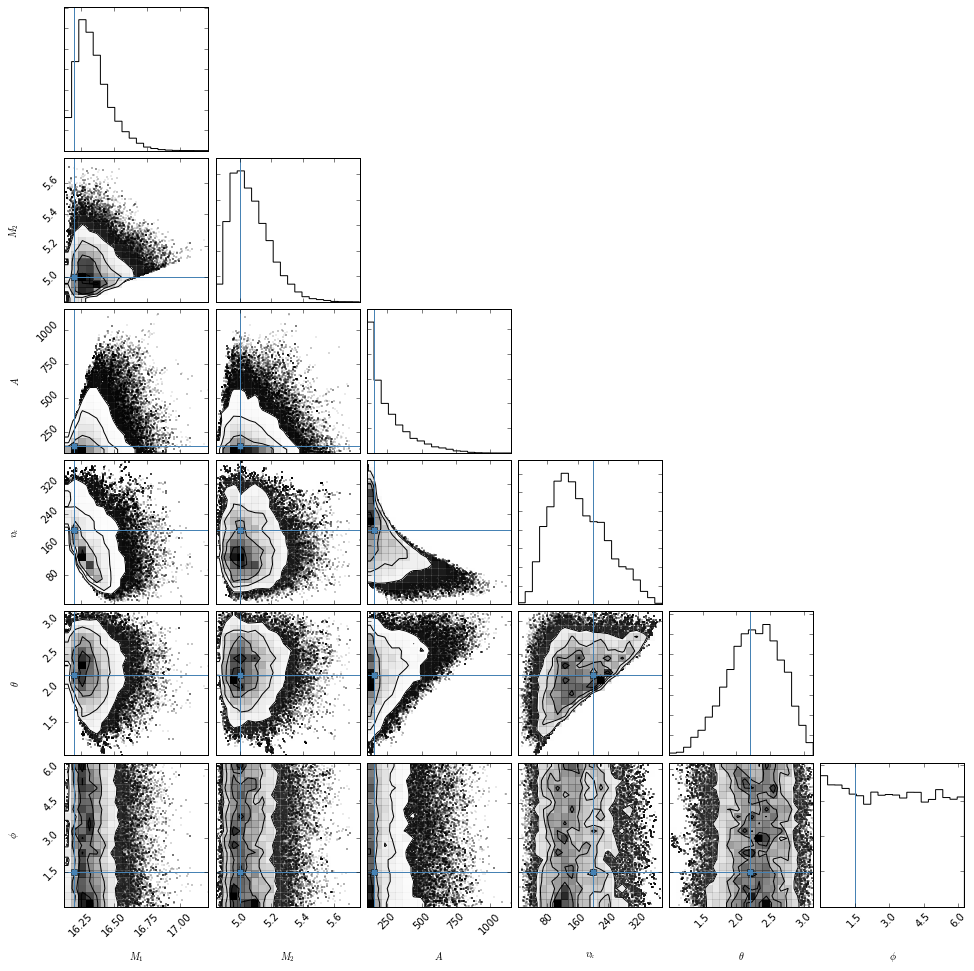

In [236]:
print sampler.lnprobability[:,0]

truths = [M1, M2, A, v_k, theta, phi]
labels = [r"$M_1$", r"$M_2$", r"$A$", r"$v_k$", r"$\theta$", r"$\phi$"]
fig = corner.corner(sampler.flatchain, labels=labels, truths=truths)

In [ ]:
sampler = run_emcee(16.5, 1.0e30, 2.0*asec_to_rad, 20.0, nburn=5000, nsteps=5000)

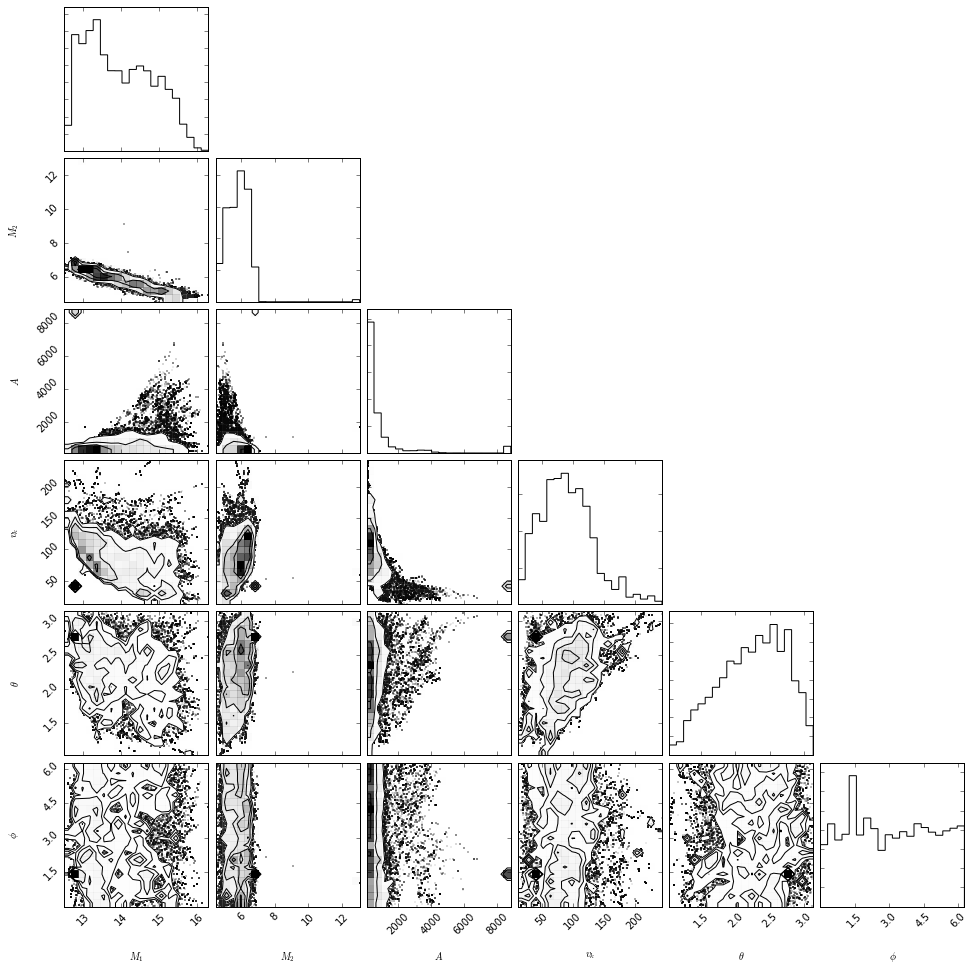

In [92]:
labels = [r"$M_1$", r"$M_2$", r"$A$", r"$v_k$", r"$\theta$", r"$\phi$"]
fig = corner.corner(sampler.flatchain, labels=labels)

plt.savefig("../plots/sample_corner.pdf")

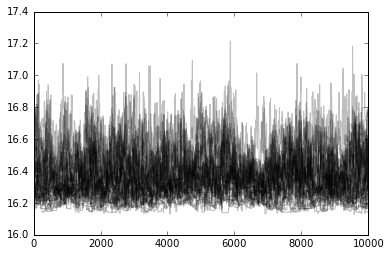

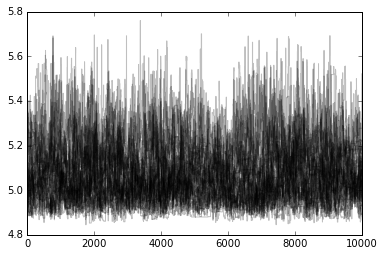

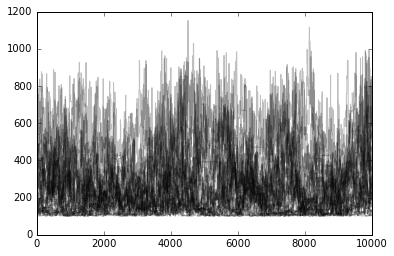

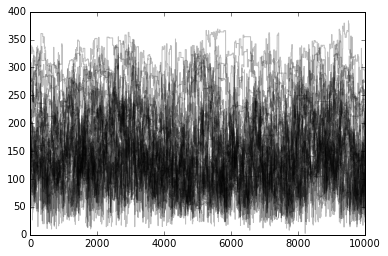

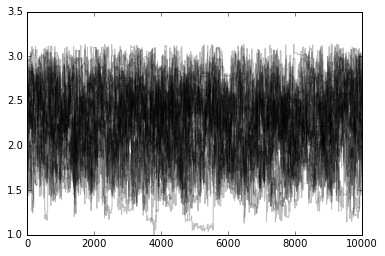

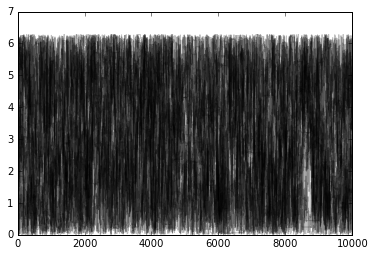

In [237]:
for i in range(sampler.dim):
    plt.figure()
    for chain in sampler.chain[...,i]:
        plt.plot(chain, alpha=0.25, color='k', drawstyle='steps')



In [28]:
def P_to_A(M1, M2, P):
    mu = G * (M1 + M2) * Msun_to_g
    n = 2.0*np.pi / P / yr_to_sec
    A = np.power(mu/(n*n), 1.0/3.0) / AU_to_cm
    return A
    
def A_to_P(M1, M2, A):
    mu = G * (M1 + M2) * Msun_to_g
    n = np.sqrt(mu/(A**3 * AU_to_cm**3))
    P = 2.0*np.pi / n
    return P / yr_to_sec



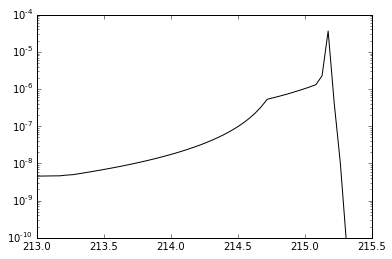

In [38]:
M_1_a = 1.35
M_2_a = 4.0
P_i = 10.0 # yrs
v_wind = 20.0 # in km/s

time = np.linspace(170.0, func_sse_tmax(M_2_a), 1000.0)

m_out, mdot_out, r_out = func_get_sse_star(mass, time)

A_i = P_to_A(M_1_a, M_2_a, P_i)
A_f = A_i * (M_1_a + M_2_a) / (M_1_a + m_out)

f_capture = (GGG*M_NS / (v_wind*v_wind*A_f * AU_to_cm / Rsun_to_cm))**2

#plt.plot(time, A_f, color='k')
#plt.plot(time, f_capture, color='k')


plt.plot(time, mdot_out, color='k')
plt.yscale('log')
plt.xlim(213.0, 215.5)
plt.ylim(1.0e-10, 1.0e-4)

plt.show()